# INTRODUCTION TO MACHINE LEARNING PROJECT

## Imports

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import time
from tqdm import tqdm

np.random.seed(42)

# NOTES
# TODO weighted knn, weighting the closest points 
# TODO for the best k, redo cross val to tune the best distance metric
# TODO rajouter std dans les comparaisons
# TODO calculate the bound of R(h)<=R^(h)+Variance, but need to find the complexity measure of knn
# TODO plot the bias/variance tradeoff by showing that small value of k gives a low bias but high variance and inversely symmetrical
# TODO tuning the best distance metric for each feature, take each feature separately, cross val the distance metric and then get a matrix of distance metrics


## Loading Data

In [162]:
def load_data(dataset_file):
    return np.loadtxt(dataset_file, delimiter=',')

data = load_data('./waveform.data')

# Splitting the features and the labels into two different arrays
features = np.array(data[:,:data.shape[1]-1])

# Normalization of the features such that each feature has a mean = 0 and std = 1
def normalization(feat_to_norm) :
    new = np.empty(shape=feat_to_norm.shape)
    for i in range(feat_to_norm.shape[1]) :
        mean = np.mean(feat_to_norm[:,i])
        std = np.std(feat_to_norm[:,i])
        new[:,i] = (feat_to_norm[:,i] - mean) / std
    return new

features = normalization(feat_to_norm=features)

labels = np.array(data[:,data.shape[1]-1:])


###  Creating the dataset in python

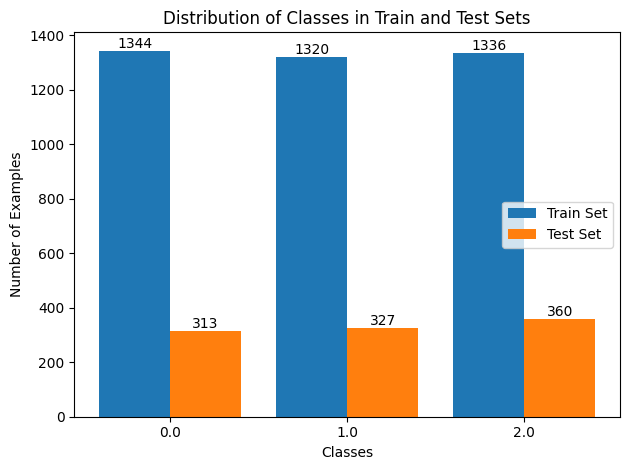

In [163]:
def train_test_split(features, labels, train_ratio):
    assert features.shape[0] == labels.shape[0], "Error : dimensions of features and labels should be the same"

    # Randomly shuffling the dataset's indices to pick randomly the training and test examples
    shuffled_indices = np.arange(features.shape[0])
    np.random.shuffle(shuffled_indices)
    train_size = int(len(shuffled_indices) * train_ratio)
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]

    x_set = features[train_indices]
    x_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]

    assert x_set.shape[0] == y_train.shape[0], "Error : creation of training set went wrong."
    assert x_test.shape[0] == y_test.shape[0], "Error : creation of testing set went wrong."

    return x_set, x_test, y_train, y_test

#Creation of the training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(features, labels, 0.8)

#Plotting the distribution of the training and test set
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots()
bar_width = 0.4
train_positions = np.arange(len(train_classes))
test_positions = train_positions + bar_width
bar1 = ax.bar(train_positions, train_counts, bar_width, label='Train Set')
bar2 = ax.bar(test_positions, test_counts, bar_width, label='Test Set')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Examples')
ax.set_title('Distribution of Classes in Train and Test Sets')
ax.set_xticks(train_positions + bar_width / 2)
ax.set_xticklabels(train_classes)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
ax.legend()
plt.tight_layout()
plt.show()


### Various functions

In [164]:
def euclidian_distance(x1,x2):
    return float(np.sqrt(np.sum((np.array(x1) - np.array(x2))**2)))

# Returns an array with the euclidian distances from x to every x' in x_array
def euclidian_dist_array(x, x_array):
    return np.linalg.norm(x_array - x, axis=1)

# Returns a matrix with the distance for each point of matrixA with respect to matrixB
def distance_matrix(matrixA, matrixB):
    #return scipy.spatial.distance_matrix(matrixA, matrixB, p=2)
    res = np.zeros((matrixA.shape[0], matrixB.shape[0]))
    for i in range(matrixA.shape[0]):
        distance = euclidian_dist_array(matrixA[i], matrixB)
        res[i] = distance
    return res

def accuracy(nb_true, nb_total):
    return (nb_true * 100) / nb_total


#### PCA functions

## KNN Algorithm

In [165]:
# Compute and returns the majority class from the features amongst the k nearest neighbors of a new input
# OR the distances needs to be precomputed and passed in distance_mat
# labels is composed of the corresponding labels for each value of the distance_mat

def knn(labels, k, distance_tab=None, new_input=None, features_set=None):
    # Getting the precomputed distances from the distance_tab if it is passed in the arguments
    if distance_tab is not None:
        if (len(labels) != len(distance_tab)):
            raise ValueError("Error : The number of labels doesn't correspond to the number of distances.")
        dist_array = distance_tab
    # Else compute the distance tab from new_input to the set
    else :
        if new_input is not None and features_set is not None :
            if (len(labels) != features_set.shape[0]):
                raise ValueError("Error : number of labels not corresponding to the number of samples of features_set")
            dist_array = euclidian_dist_array(new_input, features_set)

    # Getting the k nearest distances
    if len(dist_array) > k:
        k_nearest_indices = np.argpartition(dist_array, k)[:k]
    else :  #for CNN when there is only one element in features_set, maybe find a way to avoid this
        k_nearest_indices = np.argsort(dist_array)

    # Get the labels of the k nearest neighbors
    classes = labels[k_nearest_indices].ravel()

    # Count the number of occurences of each class Yj among the k nearest neighbors
    counts = np.bincount(classes[:k].astype(int))

    # Return the class with the highest count
    majority_class = np.argmax(counts)

    return majority_class


#### PCA functions

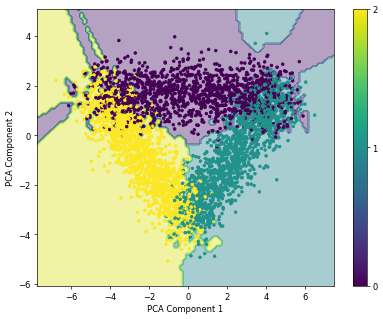

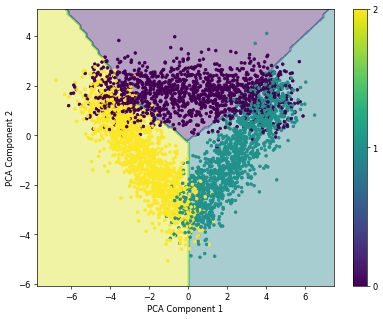

In [166]:
def pca_train(matrix, nb_dim) : 
    # Substract the mean of every feature 
    mean_vector = np.mean(matrix, axis=0)
    centered_data = matrix - mean_vector

    # Calculate the covariance matrix
    N = matrix.shape[0]  
    cov = (centered_data.T @ centered_data) / (N - 1)

    # Calculate the trace to calculate the variance explained
    trace = np.trace(cov)

    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the number of eigenvectors you want (= nb_dim)
    top_eigenvalues = eigenvalues[:nb_dim]
    top_eigenvectors = eigenvectors[:, :nb_dim]
    
    # Calculate the new projection of each data point 
    new = centered_data @ top_eigenvectors

    # return the variance explained by the projection
    variance = np.sum(top_eigenvalues) / trace

    return new, mean_vector, top_eigenvectors, variance

def pca_transform(matrix, mean_vector, top_eigenvectors):
    # Center the test data using the training mean
    centered_data = matrix - mean_vector

    # Project the test data onto the top eigenvectors
    new = centered_data @ top_eigenvectors

    return new

def plot_pca(x,y):
    plt.figure(figsize=(8, 6), dpi=60)
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', marker='o', s=10)
    plt.colorbar(scatter, ticks=[0,1,2])
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

def plot_pca_boundaries(x, y, k, resolution=400):
    # Create a mesh grid over the feature space
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Predict for each point in the mesh grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    z = [knn(labels=y, k=k, new_input=grid_points[i], features_set=x) for i in range(len(grid_points))]
    
    # Reshape z to match the shape of xx and yy
    z = np.array(z).reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(8, 6), dpi=60)
    plt.contourf(xx, yy, z, alpha=0.4, cmap='viridis')
    #plt.scatter(grid_points[:, 0], grid_points[:, 1], c=z, cmap='viridis', alpha=0.4)
    
    # Scatter plot of the actual data
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', marker='o', s=10)
    plt.colorbar(scatter, ticks=[0,1,2])
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

x_pca, _,_,_ = pca_train(x_train, 2)

plot_pca_boundaries(x_pca, y_train, 1, resolution=100)

plot_pca_boundaries(x_pca, y_train, 1000, resolution=100)


### Linear Discriminant Analysis functions

In [167]:
def lda_train(features, labels, nb_dim):
    # Compute the d-dimensional mean vectors for the c classes
    classes = np.unique(labels)
    mean_vectors = []
    labels = labels.ravel()
    for c in classes:
        mean_vectors.append(np.mean(features[labels == c], axis=0))
    mean_vectors = np.array(mean_vectors)
    
    # Compute the within-class and between-class scatter matrices
    n_features = features.shape[1]
    within_matrix = np.zeros((n_features, n_features))
    between_matrix = np.zeros((n_features, n_features))
    overall_mean = np.mean(features, axis=0).reshape(n_features, 1)
    classes = np.unique(labels)

    for c, mean_vec in zip(classes, mean_vectors): # Sum over the classes
        # Compute within-class scatter
        class_samples = features[labels.ravel() == c]  
        class_scatter = np.sum([(row.reshape(n_features, 1) - mean_vec.reshape(n_features, 1))
                                @ (row.reshape(n_features, 1) - mean_vec.reshape(n_features, 1)).T
                                for row in class_samples], axis=0) # Sum of all the examples in class c
        within_matrix += class_scatter

        # Compute between-class scatter
        n_cls = class_samples.shape[0]
        mean_vec = mean_vec.reshape(n_features, 1)
        between_matrix += n_cls * (mean_vec - overall_mean) @ (mean_vec - overall_mean).T

    
    # Compute the eigenvectors and the eigenvalues
    eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_matrix).dot(between_matrix))
    
    # Select the nb_dim top eigenvectors
    sorted_indices = np.argsort(abs(eigen_values))[::-1]
    top_eigenvectors = eigen_vectors[:, sorted_indices[:nb_dim]]
    
    # Transform the data
    features_LDA = features.dot(top_eigenvectors)
    
    return features_LDA, top_eigenvectors

def lda_transform(matrix, top_eigenvectors):
    return matrix.dot(top_eigenvectors)

def plot_lda(x,y):
    plt.figure(figsize=(8, 6), dpi=60)
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', marker='o', s=10)
    plt.colorbar(scatter, ticks=[0,1,2])
    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.show()


### Metrics calculation : accuracy, confusion matrix, etc...

In [168]:
def metrics_calculation(cm):
    total_pred = np.sum(cm)
    num_classes = cm.shape[0]
    per_class_precision = []
    per_class_recall = []
    per_class_f_measure = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0

        if (precision + recall) > 0:
            f_measure = 2 * precision * recall / (precision + recall)
        else:
            f_measure = 0

        per_class_precision.append(precision)
        per_class_recall.append(recall)
        per_class_f_measure.append(f_measure)

    avg_f_measure = np.mean(per_class_f_measure)
    accuracy = np.trace(cm) / total_pred
    error = 1 - accuracy

    return accuracy, error, avg_f_measure


In [169]:
# Returns the accuracy, confusion matrix of the prediction of the test set amongst the train set
# distance_mat : precomputed distances between train set and test set

def prediction_metrics(y_set_train, y_set_test, k, distance_mat=None, x_set_train=None, x_set_test=None):
    len_y_set_test = len(y_set_test)
    classes = np.unique(y_set_test)
    nb_classes = len(classes)
    confusion_matrix = np.zeros((nb_classes, nb_classes))

    # Using the precomputed distance matrix if provided, else using the x_set_train and x_set_test and computing the distances in the knn function
    knn_function = lambda i : knn(y_set_train, k, distance_mat[i]) if distance_mat is not None else knn(y_set_train, k, new_input=x_set_test[i], features_set=x_set_train)

    # Predict the class for each point of the set test amongst the set train
    for i in range(len_y_set_test) :
        y_pred = knn_function(i)
        y_actual = y_set_test[i, 0]

        # Filling the confusion matrix
        index_pred = np.where(classes == y_pred)[0][0]
        index_actual = np.where(classes == y_actual)[0][0]
        confusion_matrix[index_actual, index_pred] += 1

    accuracy, error, f_measure = metrics_calculation(cm = confusion_matrix)
    return accuracy, error, f_measure, confusion_matrix


# Tuning k by cross-validation

### Creating the k folds

In [170]:
# Splitting the training set into x_subsets for cross-validation
def k_folds(x_training_set, y_training_set, nb_folds):
    if nb_folds > x_training_set.shape[0]:
        raise ValueError("Error : number of folds exceeding the number of samples in the dataset.")
    # Shuffling the sets to get random folds
    indices = np.arange(x_training_set.shape[0])
    np.random.shuffle(indices)
    x_shuffled = x_training_set[indices]
    y_shuffled = y_training_set[indices]
    
    # Split the shuffled data into folds
    x = np.array_split(x_shuffled, nb_folds)
    y = np.array_split(y_shuffled, nb_folds)

    assert len(x) == len(y), "Error creating the subsets for cross-validation"
    return x, y

nb_folds = 5
x_subsets, y_subsets = k_folds(x_train, y_train, nb_folds)


### Pre-computing the distances of the k folds between them

In [171]:
# Returns a list of distances matrix of each fold of x_folds against the remaining folds
def list_distance_matrix(nb_folds, x_folds):
    # Precompute the distances between each fold and the k-1 other folds to accelerate computation
    list_dist_mat = []
    for i in range(nb_folds) : 
        x_tmp_training = np.concatenate([x_folds[j] for j in range(nb_folds) if j != i], axis=0)
        x_val_fold = x_folds[i]
        dist_mat = distance_matrix(x_val_fold, x_tmp_training)
        list_dist_mat.append(dist_mat)
    return list_dist_mat

list_dist_mat = list_distance_matrix(nb_folds=nb_folds, x_folds=x_subsets)


### Cross-validation algorithm

In [172]:
# Returns the metrics for a given k using cross-validation
def cross_validation(k, y_train_folds, nb_folds, list_dist_mat):
    fold_accuracies = []
    fold_errors = []
    fold_f_measures = []
    fold_confusion_matrices = []

    # Computing the metrics for each fold taken once(as a validation fold) over the k-1 training folds
    for i in range(nb_folds):
        # Remove the validation set from the training set
        y_tmp_training = np.concatenate([y_train_folds[j] for j in range(nb_folds) if j != i], axis=0)

        # Take the remaining fold as the validation fold
        y_val_fold = y_train_folds[i]
        
        fold_accuracy, fold_error, fold_f_measure, fold_cm = (prediction_metrics(distance_mat=list_dist_mat[i],
                                                     y_set_train=y_tmp_training, 
                                                     y_set_test=y_val_fold, 
                                                     k=k))
        fold_accuracies.append(fold_accuracy)
        fold_errors.append(fold_error)
        fold_f_measures.append(fold_f_measure)
        fold_confusion_matrices.append(fold_cm)
    
    # Returning the mean of the metrics
    mean_accuracy = np.mean(fold_accuracies)
    mean_error = np.mean(fold_errors)
    mean_f_measure = np.mean(fold_f_measures)
    mean_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
    return mean_accuracy, mean_error, mean_f_measure, mean_confusion_matrix


### Finding the best k using cross-validation

In [173]:
# Returns the best k using cross-validation
def tuning_k(nb_folds, y_folds, k_range, list_dist_mat):
    list_accuracies = []
    list_errors = []
    list_f_measures = []
    list_confusion_matrices = []

    # Iterate over the whole k range
    for k in tqdm(k_range) : 
        # Get the mean metrics for this k over the entire folds using cross-validation
        mean_acc, mean_error, mean_f_measure, mean_cm = cross_validation(k, y_folds, nb_folds, list_dist_mat)
        list_accuracies.append(mean_acc)  
        list_errors.append(mean_error)
        list_f_measures.append(mean_f_measure)
        list_confusion_matrices.append(mean_cm)

    max_accuracy = max(list_accuracies)
    best_k = k_range[list_accuracies.index(max_accuracy)] 

    # Returning the best k found, the mean accuracies for each k over the folds, and the mean CM for each k
    return best_k, list_accuracies, list_errors, list_f_measures, list_confusion_matrices

k_max = int(x_train.shape[0] - (x_train.shape[0] / nb_folds))
k_range = range(1, 200)
best_k, accuracies, errors, f_measures, confusion_matrices = tuning_k(nb_folds=nb_folds, y_folds=y_subsets, k_range=k_range, list_dist_mat=list_dist_mat)
max_accuracy = max(accuracies)


100%|██████████| 199/199 [00:12<00:00, 15.73it/s]


### Plotting of the accuracies with respect to k

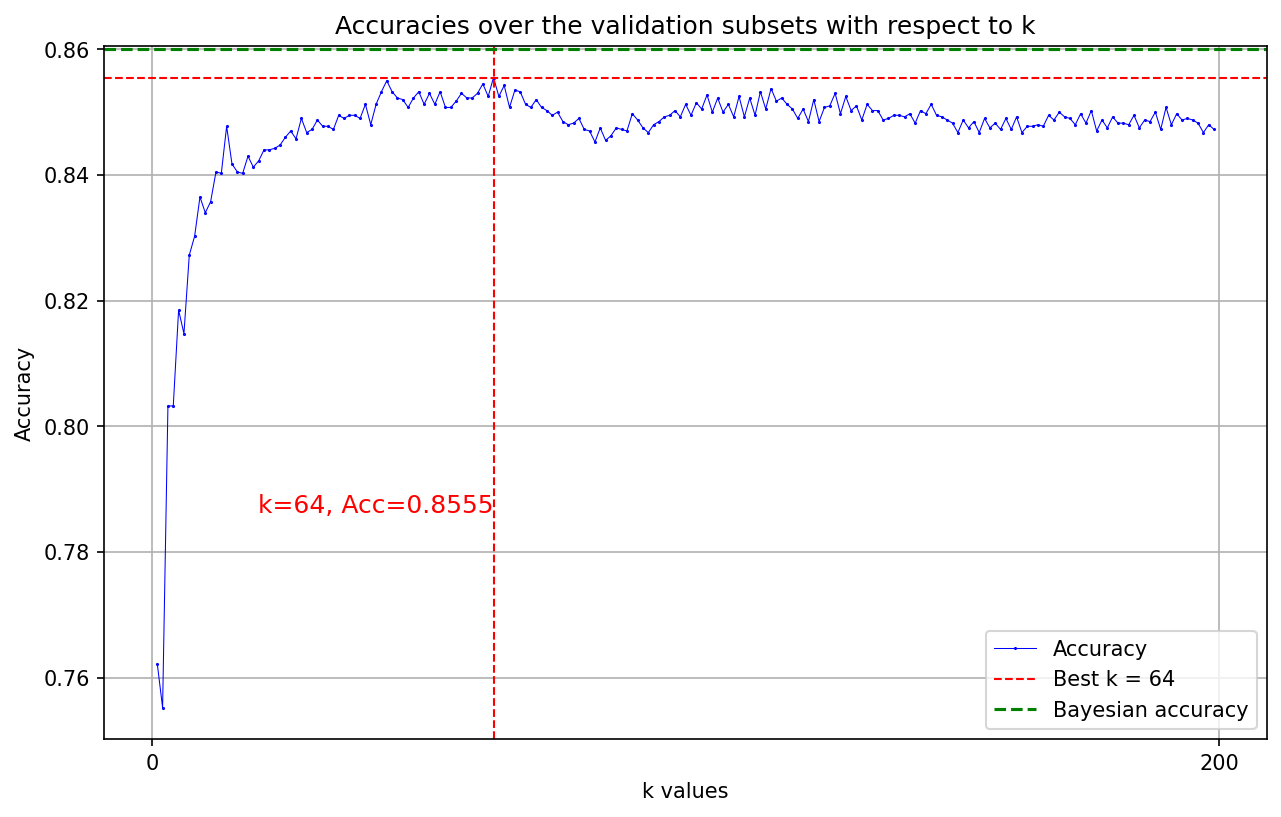

In [174]:
def plot_accuracies(tab_accuracies, y_accuracy, x_k, title):
    plt.figure(figsize=(10, 6), dpi=150) 
    plt.plot(k_range, tab_accuracies, label='Accuracy', marker='o', color='b',markersize=0.5,linestyle='-', linewidth=.5)
    plt.axvline(x=x_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {best_k}')
    plt.axhline(y=y_accuracy, color='r', linestyle='--', linewidth=1)
    plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
    plt.text(x_k, y_accuracy-0.07, f'k={x_k}, Acc={y_accuracy:.4f}', 
            horizontalalignment='right', verticalalignment='bottom', 
            color='red', fontsize=12)
    plt.xlabel('k values')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, max(k_range)+2, 200)) 
    #plt.axhline(y=(1/3), color='orange', linestyle='--', label=f'Random Guessing')
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.show()

plot_accuracies(accuracies, max_accuracy, best_k, "Accuracies over the validation subsets with respect to k")


### Confusion matrix of the best k

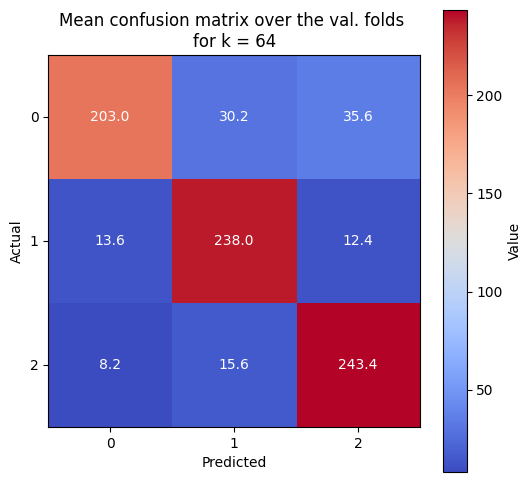

In [175]:
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, cmap='coolwarm')
    plt.colorbar(label='Value')
    for (i, j), value in np.ndenumerate(matrix):
        plt.text(j, i, f'{value}', ha='center', va='center', color='white')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.xticks(np.arange(matrix.shape[1]), ['0', '1', '2'])
    plt.yticks(np.arange(matrix.shape[0]), ['0', '1', '2'])
    plt.show()

confusion_mat_best_k = confusion_matrices[accuracies.index(max_accuracy)]
plot_confusion_matrix(confusion_mat_best_k,"Mean confusion matrix over the val. folds \nfor k = "+str(best_k))


### Prediction on the test set using the best k found
We now calculate the accuracy on the test set using the k found by cross-validation.\
Here, the accuracy can be over 0.86 as the test set drawn from the data is not exactly representative of the underlying distribution

Accuracy : 0.86


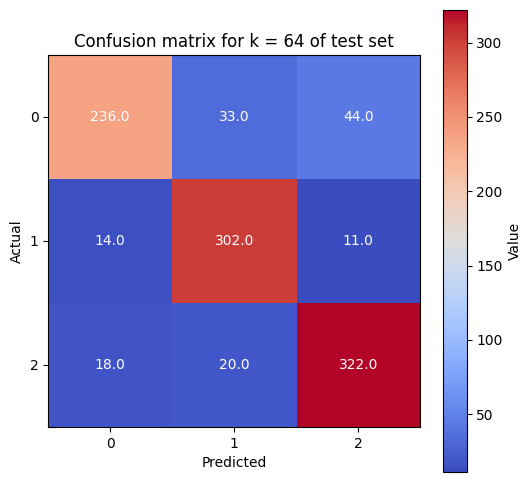

In [176]:
test_acc, test_error, test_f_measure, test_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=best_k, x_set_train=x_train, x_set_test=x_test)
print("Accuracy : "+str(test_acc))
plot_confusion_matrix(test_cm,"Confusion matrix for k = "+str(best_k)+" of test set")

test_accuracies = []
test_errors = []
test_f_measures = []
dist_mat_test_train = distance_matrix(x_test, x_train)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=k, distance_mat=dist_mat_test_train)
    test_accuracies.append(k_acc)
    test_errors.append(k_error)
    test_f_measures.append(k_f_measure)


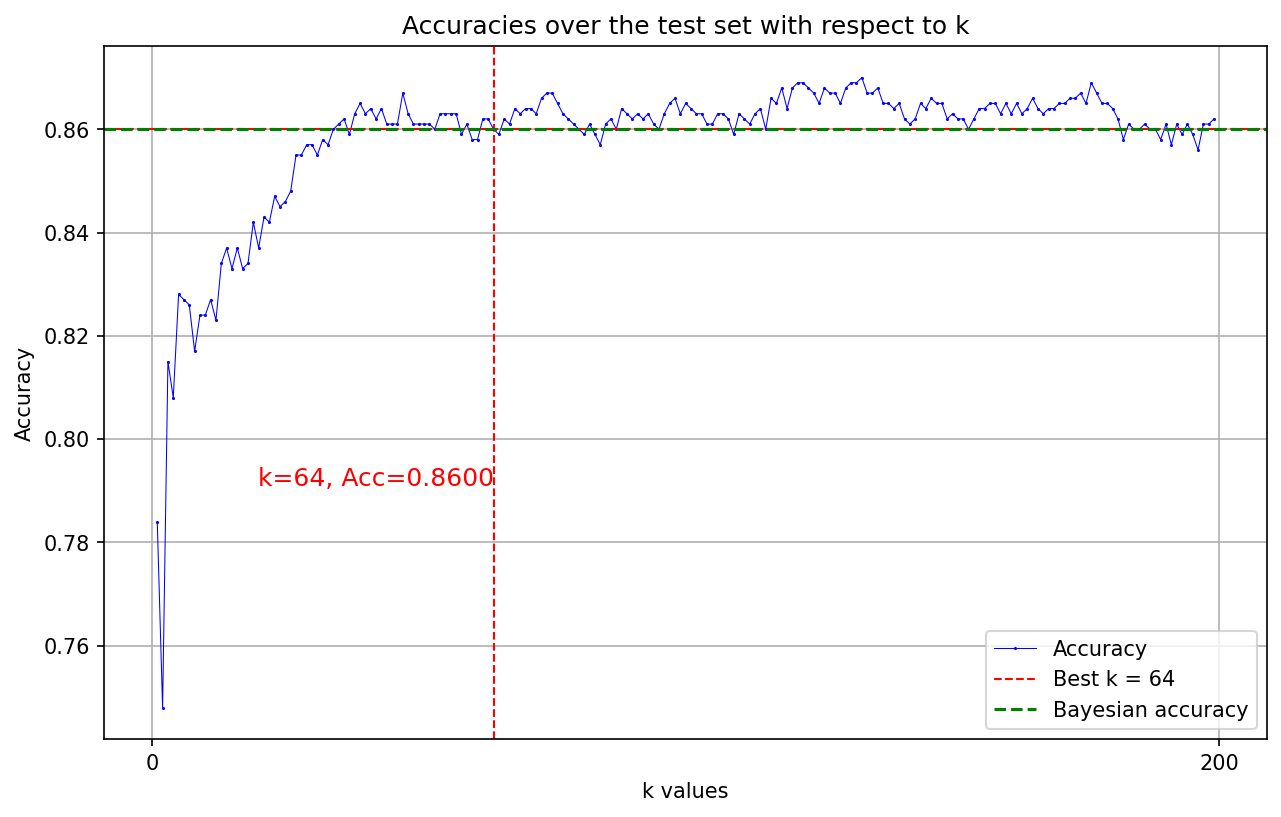

In [177]:
plot_accuracies(test_accuracies, test_acc, best_k,"Accuracies over the test set with respect to k")


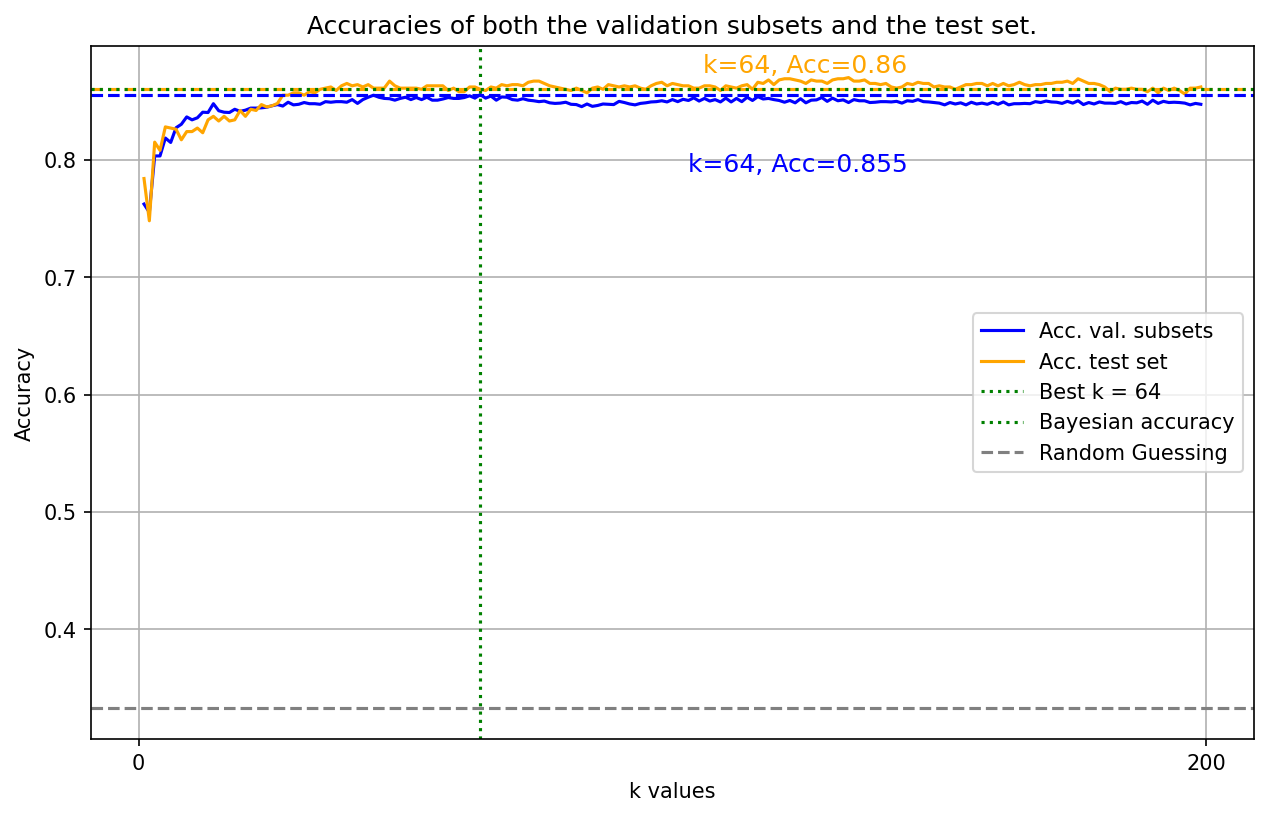

In [178]:
plt.figure(figsize=(10, 6), dpi=150) 
plt.plot(k_range, accuracies, label='Acc. val. subsets', color='b',linestyle='-')
plt.plot(k_range, test_accuracies, label='Acc. test set', color='orange',linestyle='-')
plt.axvline(x=best_k, color='g', linestyle=':', label=f'Best k = {best_k}')
plt.axhline(y=max_accuracy, color='b', linestyle='--')
plt.axhline(y=test_acc, color='orange', linestyle='--')
plt.axhline(y=.86, color='g', linestyle=':', label=f'Bayesian accuracy')
plt.text(best_k+80, max_accuracy-0.07, f'k={best_k}, Acc={max_accuracy:.3f}', 
            horizontalalignment='right', verticalalignment='bottom', 
            color='b', fontsize=12)
plt.text(best_k+80, test_acc+0.01, f'k={best_k}, Acc={test_acc:.2f}', 
            horizontalalignment='right', verticalalignment='bottom', 
            color='orange', fontsize=12)
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_range)+2, 200)) 
plt.axhline(y=(1/3), color='grey', linestyle='--', label=f'Random Guessing')
plt.grid(True)
plt.legend()
plt.title("Accuracies of both the validation subsets and the test set.")
plt.show()


# Reducing complexity

### Data Reduction : Step 1

Initial data :


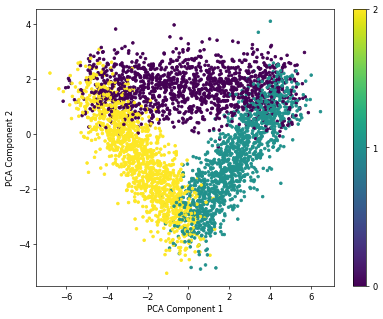

----------------
[0, 9, 12, 13, 14, 16, 17, 19, 24, 27, 35, 36, 39, 42, 43, 47, 51, 54, 59, 73, 74, 81, 83, 87, 90, 94, 95, 102, 103, 114, 115, 116, 131, 143, 147, 148, 161, 175, 176, 178, 180, 181, 196, 201, 213, 214, 220, 221, 228, 231, 232, 234, 235, 236, 237, 240, 260, 261, 268, 275, 280, 284, 289, 291, 302, 308, 309, 318, 322, 325, 326, 328, 330, 331, 333, 334, 339, 345, 351, 360, 365, 366, 370, 371, 373, 374, 376, 378, 381, 382, 391, 395, 402, 409, 419, 425, 431, 439, 442, 444, 451, 452, 456, 458, 466, 473, 475, 477, 479, 480, 490, 494, 499, 509, 515, 517, 533, 536, 556, 558, 572, 574, 575, 581, 583, 587, 607, 608, 615, 616, 617, 627, 633, 637, 641, 654, 658, 660, 663, 665, 667, 668, 681, 687, 691, 694, 695, 703, 707, 708, 711, 713, 716, 731, 734, 736, 737, 739, 740, 741, 742, 743, 745, 748, 751, 760, 765, 766, 772, 774, 775, 778, 795, 800, 803, 807, 814, 818, 829, 832, 834, 845, 848, 849, 855, 856, 859, 868, 887, 889, 895, 897, 904, 905, 910, 919, 925, 926, 928, 932, 934, 944, 9

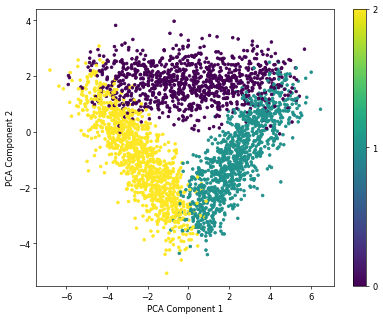

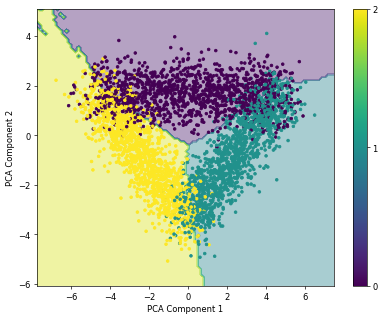

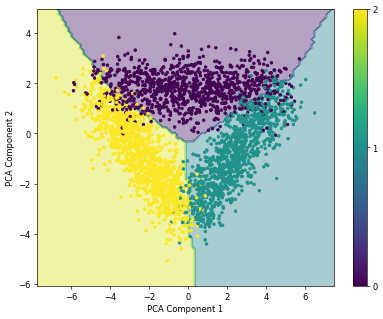

In [179]:
def remove_outliers_and_bayes_region(x_set, y_set) :
    n_k = 1
    # Splittiing randomly S into S1 and S2
    x_cleaned, y_cleaned = k_folds(x_training_set=x_set, y_training_set=y_set, nb_folds=2)

    list_indices_S1 = []
    list_indices_S2 = []

    while(True):
        # Classifying S1 with S2 using the 1-NN rule
        for i in range (len(x_cleaned[0])):
            y_pred = knn(labels = y_cleaned[1], k=n_k, new_input = x_cleaned[0][i], features_set = x_cleaned[1])
            y_actual = y_cleaned[0][i]
            # Stocking the examples misclassified
            if (y_pred != y_actual):
                list_indices_S1.append(i)

        if len(list_indices_S1) > 0:
            x_cleaned[0] = np.delete(x_cleaned[0], list_indices_S1, axis=0)
            y_cleaned[0] = np.delete(y_cleaned[0], list_indices_S1, axis=0)

        # Classifying S2 with the new set S1 using the 1-NN rule
        for i in range(len(x_cleaned[1])):
            y_pred = knn(labels = y_cleaned[0], k=n_k, new_input = x_cleaned[1][i], features_set = x_cleaned[0])
            y_actual = y_cleaned[1][i]
            # Stocking the examples misclassified
            if (y_pred != y_actual):
                list_indices_S2.append(i)

        if len(list_indices_S2) > 0:
            x_cleaned[1] = np.delete(x_cleaned[1], list_indices_S2, axis=0)
            y_cleaned[1] = np.delete(y_cleaned[1], list_indices_S2, axis=0)

        print("----------------")
        print(list_indices_S1)
        print(list_indices_S2)

        # If there is nothing in list_indices of S1 and S2 it means that all examples have been correctly classified 
        if (len(list_indices_S1) == 0 and len(list_indices_S2) == 0):
            break

        list_indices_S1.clear()
        list_indices_S2.clear()

    new_x_cleaned = np.concatenate((x_cleaned[0], x_cleaned[1]))
    new_y_cleaned = np.concatenate((y_cleaned[0], y_cleaned[1]))
    return new_x_cleaned, new_y_cleaned

print("Initial data :")
x_train_pca, mean_vector, top_eigenvectors, _ = pca_train(x_train, 2)
plot_pca(x=x_train_pca, y=y_train)

x_train_cleaned, y_train_cleaned = remove_outliers_and_bayes_region(x_set=x_train, y_set=y_train)

print("Cleaned data, outliers and examples of the bayesian region removed :")
print(x_train_cleaned.shape)
x_train_cleaned_pca = pca_transform(x_train_cleaned, mean_vector, top_eigenvectors)
plot_pca(x=x_train_cleaned_pca, y=y_train_cleaned)

plot_pca_boundaries(x_train_pca, y_train, k = best_k, resolution=100)
plot_pca_boundaries(x_train_cleaned_pca, y_train_cleaned, k = best_k, resolution=100)


### Prediction on the test set over the cleaned data

In [180]:
test_accuracies_cleaned = []
test_errors_cleaned = []
test_f_measures_cleaned = []
dist_mat_test_cleaned_train = distance_matrix(x_test, x_train_cleaned)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_train_cleaned, y_set_test=y_test, k=k,distance_mat=dist_mat_test_cleaned_train)
    test_accuracies_cleaned.append(k_acc)
    test_errors_cleaned.append(k_error)
    test_f_measures_cleaned.append(k_f_measure)


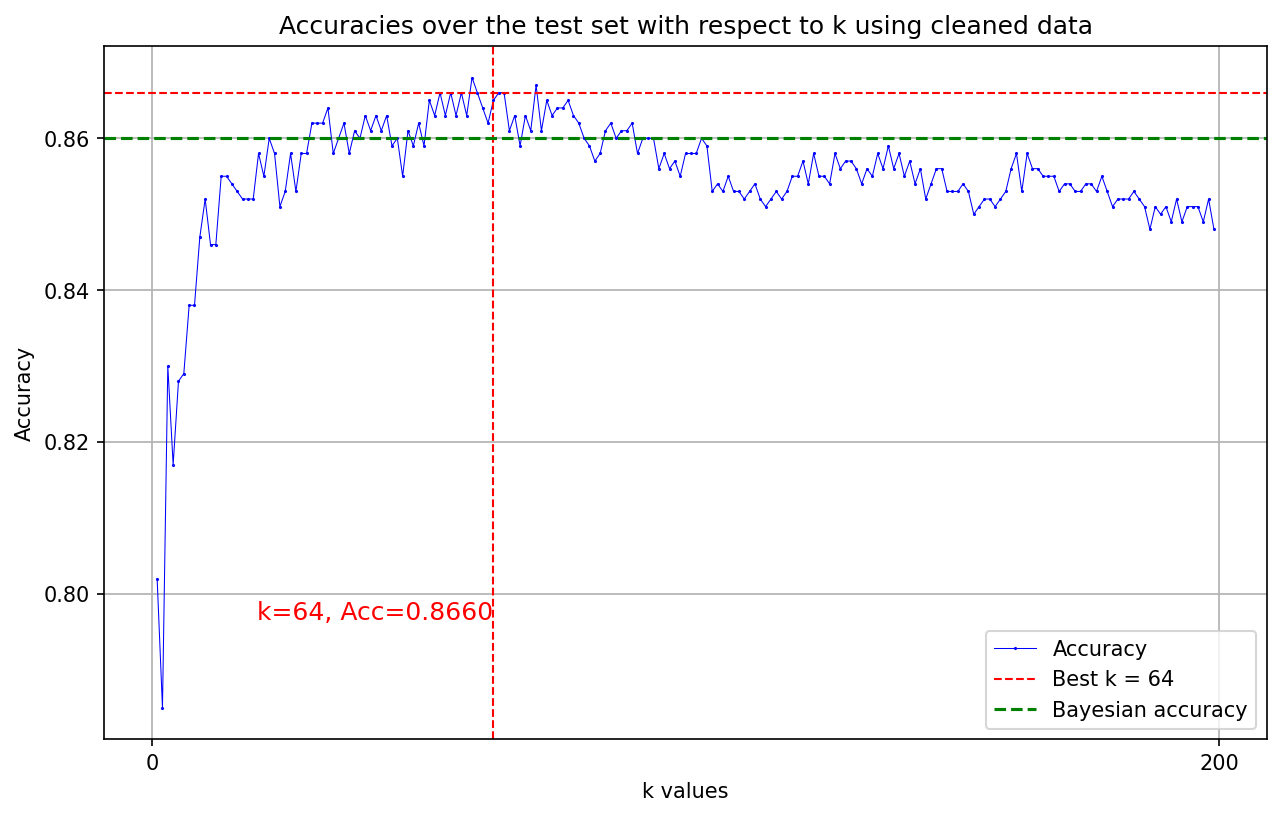

In [181]:
plot_accuracies(test_accuracies_cleaned, test_accuracies_cleaned[best_k], best_k,"Accuracies over the test set with respect to k using cleaned data")


### Data reduction : Step 2
### Condensed nearest neighbor rule

Data shape after CNN :
(787, 21)
Decision boundaries of cleaned data, before CNN:


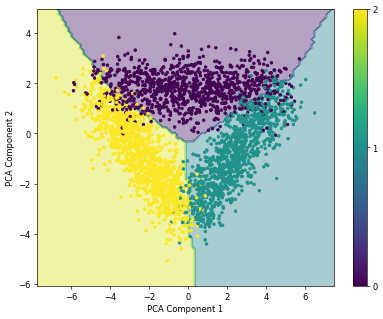

Decision boundaries after CNN :


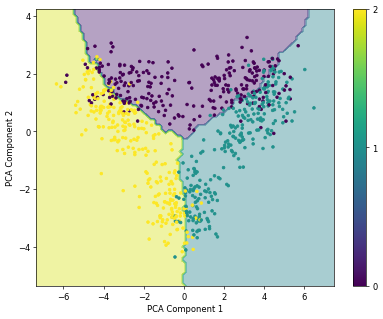

In [182]:
def condensed_nearest_neighbor(x_set, y_set):
    storage_x = np.empty((0, x_set.shape[1]))
    storage_y = np.array([])
    len_storage_prec = 0
    len_storage_actual = 0

    # Drawing randomly the first sample and putting it in Storage
    ith_example = np.random.randint(1, x_set.shape[0])
    storage_x = np.vstack([storage_x, x_set[ith_example]])
    storage_y = np.append(storage_y, y_set[ith_example])

    # While no stabilization of Storage 
    while(True):
        for i in range(len(x_set)):
            if any((storage_x == x_set[i]).all(axis=1)): # If the example is already in storage skip it
                continue

            y_pred = knn(labels=storage_y, k=1, new_input=x_set[i], features_set=storage_x)
            y_actual = y_set[i]

            # If xi is incorrectly classified we add it to the storage, else we ignore it
            if (y_pred != y_actual) :
                storage_x = np.vstack([storage_x, x_set[i]])
                storage_y = np.append(storage_y, y_set[i])
            
        len_storage_actual = len(storage_x)

        if (len_storage_prec == len_storage_actual):
            break

        len_storage_prec = len_storage_actual

    return storage_x, storage_y

x_CNN, y_CNN = condensed_nearest_neighbor(x_train_cleaned, y_train_cleaned)
print("Data shape after CNN :")
print(x_CNN.shape)

x_CNN_pca = pca_transform(x_CNN, mean_vector, top_eigenvectors)

print("Decision boundaries of cleaned data, before CNN:")
plot_pca_boundaries(x_train_cleaned_pca, y_train_cleaned, k=best_k,resolution=100)
print("Decision boundaries after CNN :")
plot_pca_boundaries(x_CNN_pca, y_CNN, k=best_k, resolution=100)


### Prediction on the test set over the condensed data

In [183]:
test_accuracies_CNN = []
test_errors_CNN = []
test_f_measures_CNN = []
dist_mat_test_CNN = distance_matrix(x_test, x_CNN)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_CNN, y_set_test=y_test, k=k, distance_mat=dist_mat_test_CNN)
    test_accuracies_CNN.append(k_acc)
    test_errors_CNN.append(k_error)
    test_f_measures_CNN.append(k_f_measure)


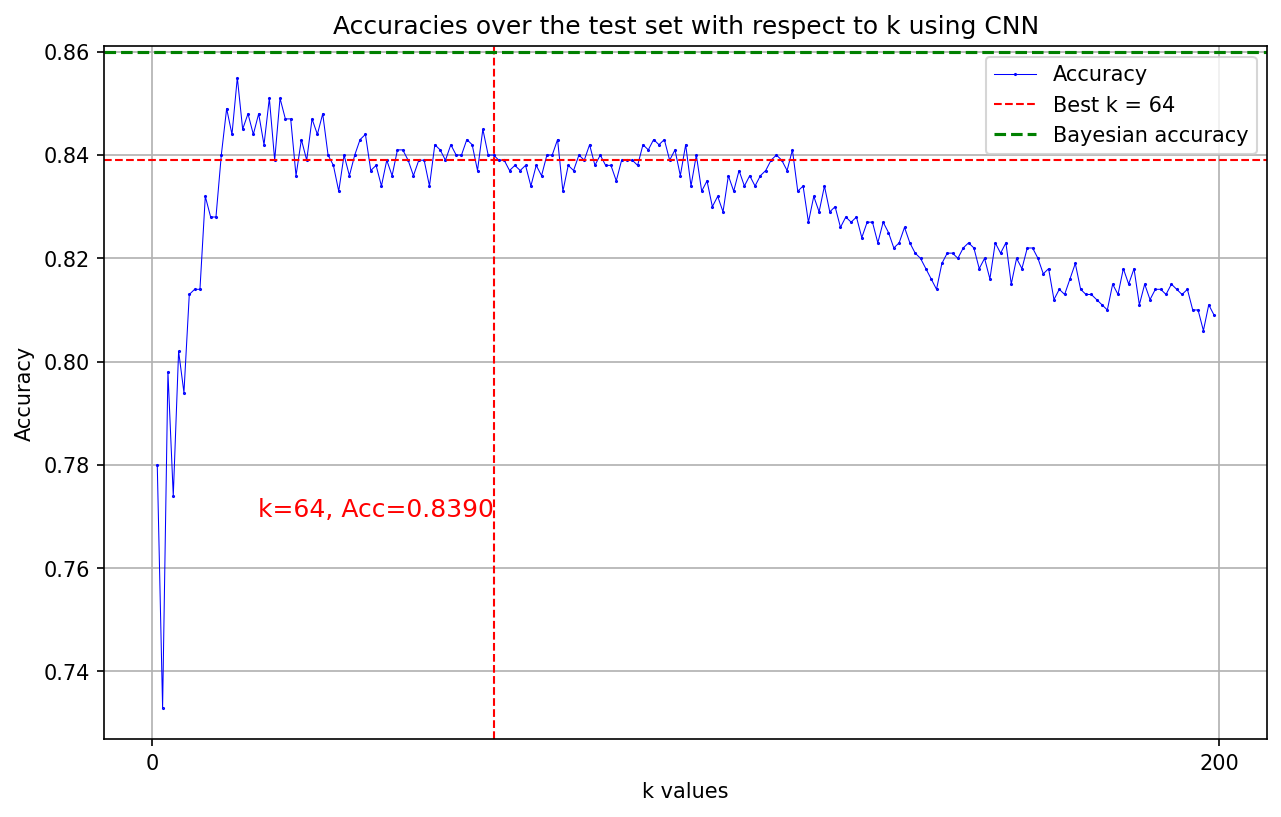

In [184]:
plot_accuracies(test_accuracies_CNN, test_accuracies_CNN[best_k], best_k,"Accuracies over the test set with respect to k using CNN")


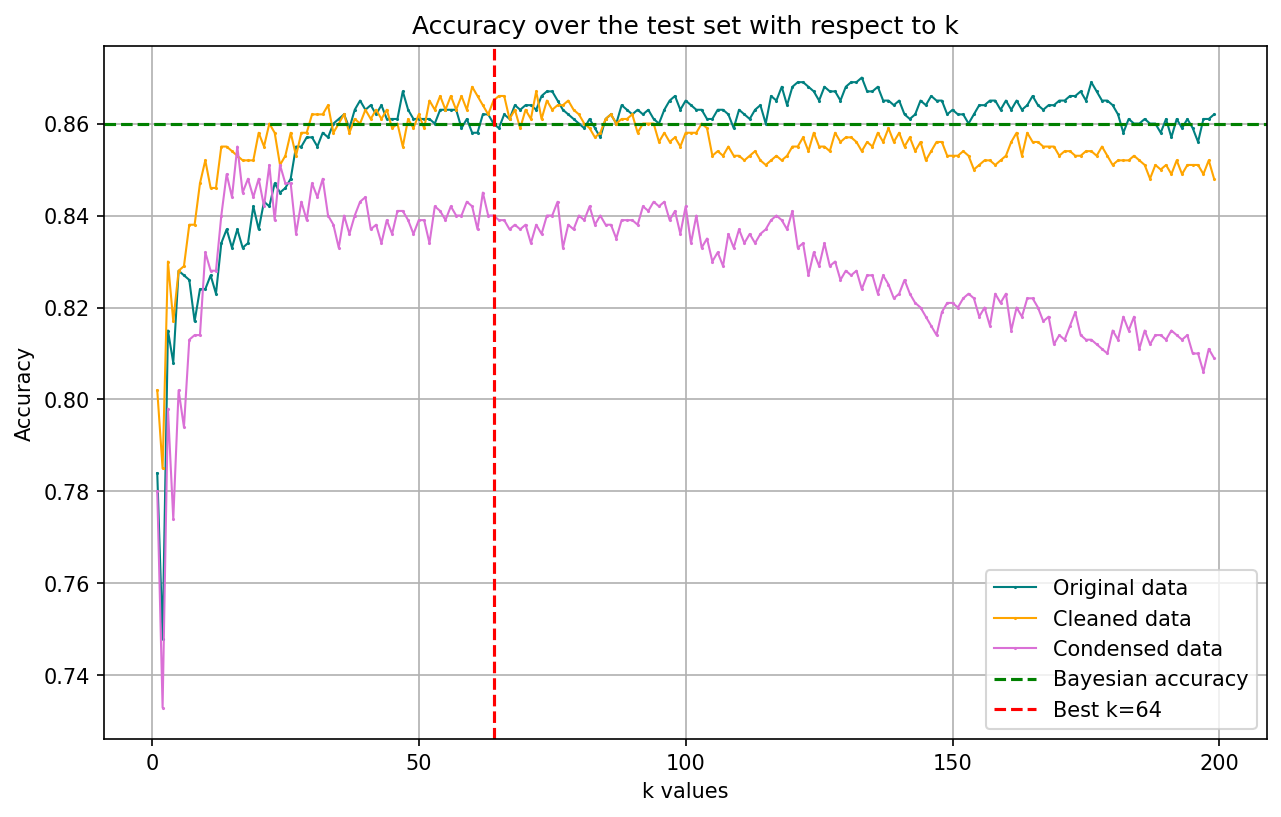

In [185]:
plt.figure(figsize=(10, 6), dpi=150) 
mksize = 0.5
plt.plot(k_range, test_accuracies, label='Original data', marker='o', color='teal',markersize=mksize,linestyle='-', linewidth=1)
plt.plot(k_range, test_accuracies_cleaned, label='Cleaned data', marker='o', color='orange', markersize=mksize, linestyle='-', linewidth=1)
plt.plot(k_range, test_accuracies_CNN, label='Condensed data', marker='o', color='orchid', markersize=mksize, linestyle='-', linewidth=1)
plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.axvline(x=best_k, color='r', linestyle='--', label='Best k='+str(best_k))
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_range)+2, 50))
#plt.yticks(np.arange(30, 90, 10)) 
#plt.axhline(y=(1/3), color='orange', linestyle='--', label=f'Random Guessing')
plt.grid(True)
plt.legend()
plt.title("Accuracy over the test set with respect to k")
plt.show()


### Speed comparison between the different data complexity

In [186]:
speed_results = []
sizes = range(10,x_test.shape[0],10) # Dataset sizes

for size in tqdm(sizes) : 
    indices = np.random.choice(x_test.shape[0], size=size, replace=False) # Select a random subset of x_train of size = 'size'
    x_test_subset = x_test[indices]
    y_test_subset = y_test[indices]

    start_time = time.perf_counter() 
    _, _, _, _ = prediction_metrics(y_set_train=y_train, y_set_test=y_test_subset, k=1, x_set_train=x_train, x_set_test=x_test_subset)
    end_time = time.perf_counter()
    elapsed_time_normal = end_time - start_time

    start_time = time.perf_counter() 
    _,_,_,_ = prediction_metrics(y_set_train=y_train_cleaned, y_set_test=y_test_subset, k=1, x_set_train=x_train_cleaned, x_set_test=x_test_subset)
    end_time = time.perf_counter()
    elapsed_time_cleaned = end_time - start_time

    start_time = time.perf_counter() 
    _,_,_,_ = prediction_metrics(y_set_train=y_CNN, y_set_test=y_test_subset, k=1, x_set_train=x_CNN, x_set_test=x_test_subset)
    end_time = time.perf_counter()
    elapsed_time_CNN = end_time - start_time

    speed_results.append((size, elapsed_time_normal, elapsed_time_cleaned, elapsed_time_CNN))

sizes, time_normal, time_cleaned, time_CNN  = zip(*speed_results)


 34%|███▍      | 34/99 [00:02<00:05, 12.20it/s]


KeyboardInterrupt: 

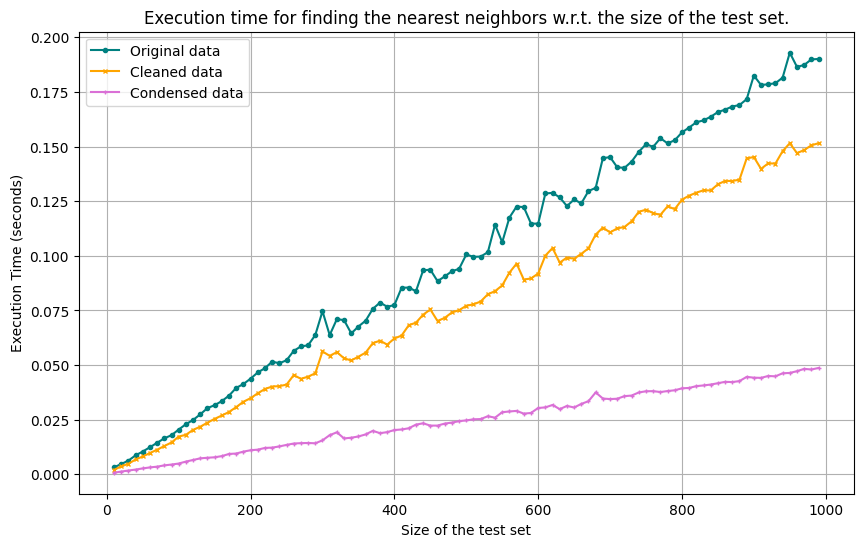

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_normal, marker='o', label="Original data", color='teal', markersize = 3)
plt.plot(sizes, time_cleaned, marker='x', label="Cleaned data", color='orange',markersize = 3)
plt.plot(sizes, time_CNN, marker='+', label="Condensed data", color='orchid',markersize = 3)
plt.xlabel("Size of the test set")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution time for finding the nearest neighbors w.r.t. the size of the test set.")
plt.legend()
plt.grid(True)
plt.show()


# Speeding-up the calculation

In [ ]:
def nearest_neighbor(x, x_array):
    current_NN = -1
    distance_NN_new_query = 0
    distance_NN = np.inf 
    for i in range(x_array.shape[0]):
        distance_NN_new_query = euclidian_distance(x, x_array[i])
        if (distance_NN_new_query < distance_NN): # If the new query is closer we update the nearest neighbor
            distance_NN = distance_NN_new_query
            current_NN = i

    return current_NN

def speed_nearest_neighbor(x, x_array, precomputed_matrix): # Only for k = 1 (for now)
    current_NN = -1
    distance_NN_new_query = 0
    distance_NN = np.inf 
    candidates = np.array(range(x_array.shape[0]))  # Start with all candidates

    while len(candidates) > 0:
        i = candidates[0]  # Pick the first candidate
        distance_NN_new_query = euclidian_distance(x, x_array[i])
        if distance_NN_new_query < distance_NN: # If the new query is closer, update the nearest neighbor
            distance_NN = distance_NN_new_query
            current_NN = i

        # Prune candidates if they are in the sphere centered at Xi of radius d(X,Xi)-dmin OR out of the sphere centered at Xi of radius d(X,Xi)+dmin
        radius_inside = distance_NN_new_query - distance_NN
        radius_outside = distance_NN_new_query + distance_NN

        distances_to_i = precomputed_matrix[i][candidates]  # Distances from the new query to current candidates
        candidates = candidates[(distances_to_i >= radius_inside) & (distances_to_i <= radius_outside)]  # Keep only valid candidates

        candidates = candidates[candidates != i] # Remove the current candidate

    return current_NN

sizes = range(200,4001,200) # Dataset sizes
n = 1000  # Number of test queries

results = []

correct_pred_normal = 0
correct_pred_speed = 0

for size in tqdm(sizes): # Compare speed for each dataset size
    correct_pred_normal = 0
    correct_pred_speed = 0
    #print(f"\nEvaluating with dataset size: {size}")

    indices = np.random.choice(x_train.shape[0], size=size, replace=False) # Select a random subset of x_train of size = 'size'
    x_train_subset = x_train[indices]
    y_train_subset = y_train[indices]

    precomputed_dist_matrix_train = distance_matrix(x_train_subset, x_train_subset) # Precompute the distance matrix for speed_nearest_neighbor

    start_time = time.perf_counter() # Measure execution time for speed_nearest_neighbor

    for i in range(n):
        speed_nn = speed_nearest_neighbor(x_test[i], x_train_subset, precomputed_dist_matrix_train)

    end_time = time.perf_counter()
    elapsed_time_speed = end_time - start_time
    #print(f"Execution time for speed nearest neighbor: {elapsed_time_speed:.10f} seconds")

    start_time = time.perf_counter() # Measure execution time for normal nearest_neighbor

    for i in range(n):
        normal_nn = nearest_neighbor(x_test[i], x_train_subset)

    end_time = time.perf_counter()
    elapsed_time_normal = end_time - start_time
    #print(f"Execution time for normal nearest neighbor: {elapsed_time_normal:.10f} seconds")

    results.append((size, elapsed_time_speed, elapsed_time_normal))

sizes, times_speed, times_normal = zip(*results) 


 40%|████      | 8/20 [00:59<01:29,  7.49s/it]


KeyboardInterrupt: 

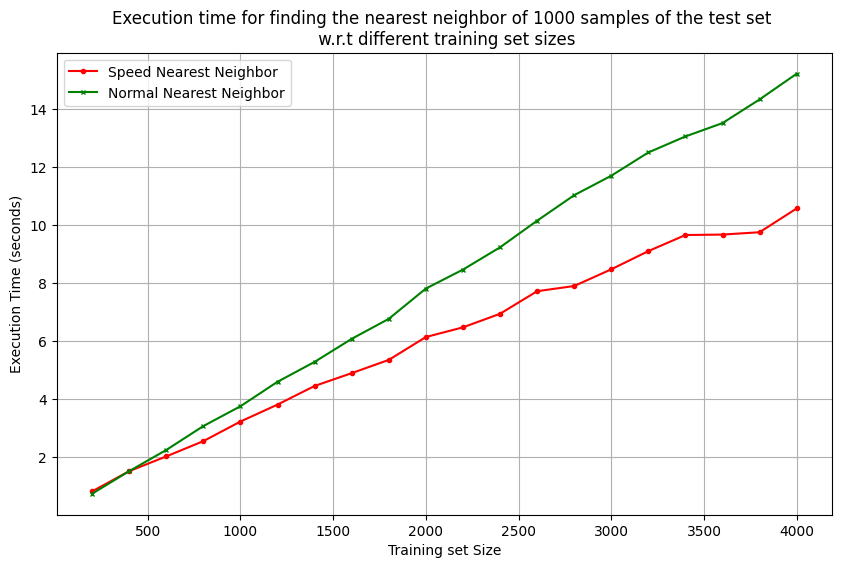

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, times_speed, marker='o', label="Speed Nearest Neighbor", color='r', markersize = 3)
plt.plot(sizes, times_normal, marker='x', label="Normal Nearest Neighbor", color='g',markersize = 3)
plt.xlabel("Training set Size")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution time for finding the nearest neighbor of "+str(n)+" samples of the test set \n w.r.t different training set sizes")
plt.legend()
plt.grid(True)
plt.show()


# Curse of dimensionnality
We show here that KNN is affected by the curse of dimensionnality.\
We calculate the mean accuracy over the test set using all the k from k_range for dimensions of PCA from 1 to 21

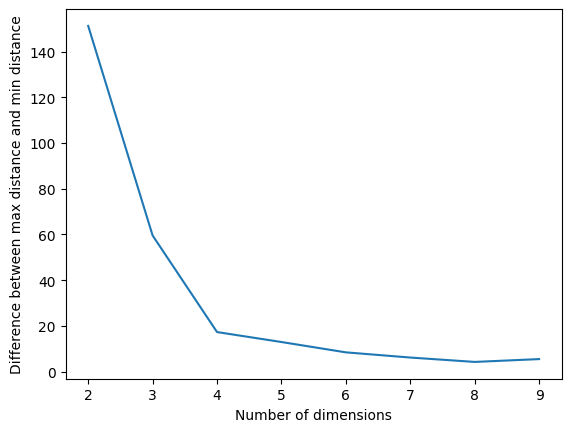

In [ ]:
# SOURCE : https://stackoverflow.com/questions/69247773/generating-a-curse-of-dimensionality-chart
import numpy as np
import matplotlib.pyplot as plt
import os
import math

deltas = []
nb_dim = 10
for N in range(2,nb_dim):
    P = [np.random.randint(-100, 100, N) for _ in range(10000)] # Generating 10000 random points
    Q = np.random.randint(-100,100,N) # Generating one random point
    diffs = [np.linalg.norm(p-Q) for p in P] # Calculating the differences between the P points and Q
    mxd = max(diffs)
    mnd = min(diffs)
    delta = (mxd-mnd)/mnd
    deltas.append( delta )

plt.plot(range(2,nb_dim),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Difference between max distance and min distance')
plt.show()


In [ ]:
k_range_pca = range(1, 1500)
nb_k = len(k_range_pca)
individual_variances = []
previous_var = 0 # To save the variance for each value of p
pca_accuracies = []
lda_accuracies = []
for p in tqdm(range(1,22)):
    x_train_pca, mean_vector, top_eigenvectors, variance = pca_train(x_train, p) # Training pca on p dimensions and projection de training set 
    x_test_pca = pca_transform(x_test, mean_vector, top_eigenvectors) # Projecting the test set intot the p dimensions

    x_train_lda, top_eigenvectors_lda = lda_train(x_train, y_train, p)
    x_test_lda = lda_transform(x_test, top_eigenvectors_lda)

    mean_acc = 0
    mean_acc_lda = 0
    distance_mat = distance_matrix(x_test_pca, x_train_pca)
    distance_mat_lda = distance_matrix(x_test_lda, x_train_lda)
    for k in k_range_pca:
        p_acc, _,_,_ = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=k, distance_mat=distance_mat)
        mean_acc += p_acc

        p_acc_lda, _,_,_ = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=k, distance_mat=distance_mat_lda)
        mean_acc_lda += p_acc_lda
    
    mean_acc = mean_acc/nb_k
    pca_accuracies.append(mean_acc)

    mean_acc_lda = mean_acc_lda/nb_k
    lda_accuracies.append(mean_acc_lda)

    individual_variances.append(variance-previous_var)
    previous_var = variance


100%|██████████| 21/21 [19:48<00:00, 56.57s/it]



We clearly see here that the mean accuracy decreases with the increase of the number of dimensions.

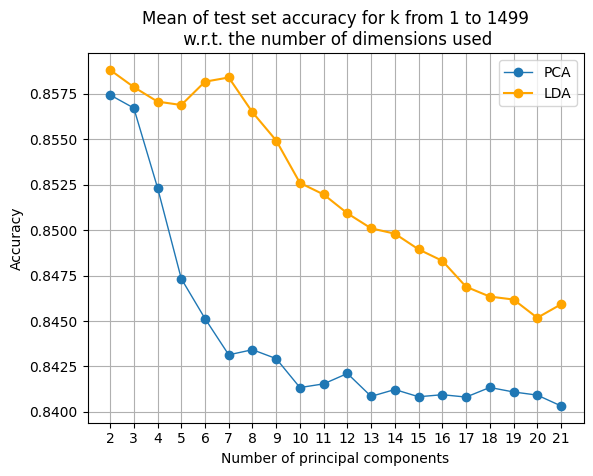

In [ ]:
p_values = range(1, 22)  # p values from 2 to 21
plt.plot(p_values[1:], pca_accuracies[1:], marker='o', linewidth=1, label='PCA')
plt.plot(p_values[1:], lda_accuracies[1:], marker='o', color='orange', label='LDA')
plt.title("Mean of test set accuracy for k from 1 to "+str(max(k_range_pca))+"\n w.r.t. the number of dimensions used")
plt.xlabel("Number of principal components")
plt.ylabel("Accuracy")
plt.xticks(np.arange(2, 22, 1)) 
plt.legend()
plt.grid(True)
plt.show()


Explained variance is also important when performing a PCA.  
But in a supervised setting, the explained variance isn't much important.

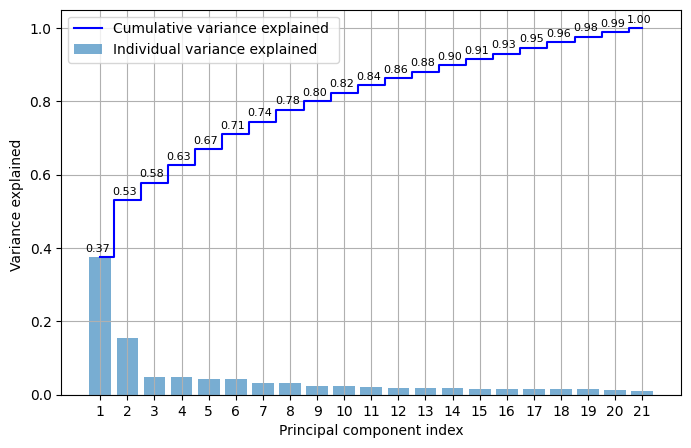

In [ ]:
cumulative_variances = np.cumsum(individual_variances)
plt.figure(figsize=(8, 5))
plt.bar(p_values, individual_variances, alpha=0.6, label="Individual variance explained ")
plt.step(p_values, cumulative_variances, where='mid', color='blue', label="Cumulative variance explained ")
plt.xticks(ticks=p_values, labels=[str(i) for i in p_values])
plt.xlabel("Principal component index")
plt.ylabel("Variance explained ")
plt.legend(loc="upper left")
for x, y in zip(p_values, cumulative_variances):
    plt.text(x-0.1, y+0.01, f"{y:.2f}", ha='center', va='bottom', fontsize=8)
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


# Imbalanced Data

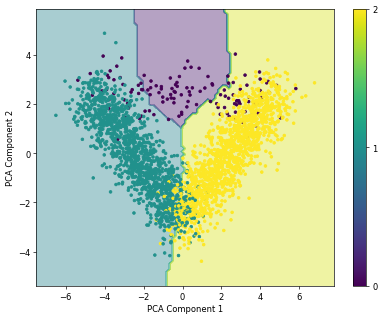

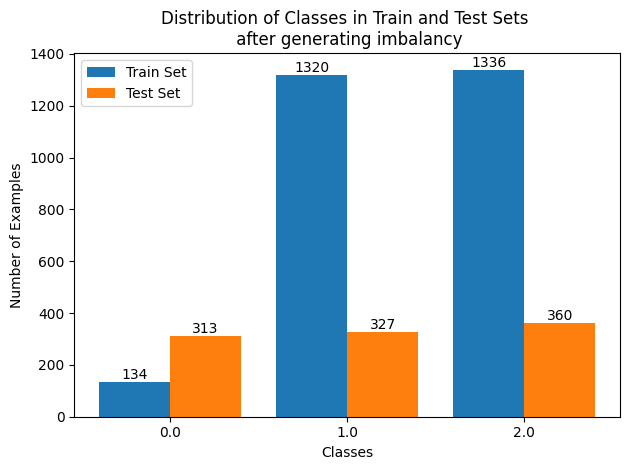

In [ ]:
# Generating imbalancy
def generate_imbalancy(X, y, num_class, imbalancy_ratio):
    imbalanced_class = num_class
    class_indices = np.where(y == imbalanced_class)[0]
    other_indices = np.where(y != imbalanced_class)[0]
    imbalancy = imbalancy_ratio
    size = int(imbalancy * len(class_indices))
    indices_kept = np.random.choice(class_indices, size, replace=False)

    x_class = X[indices_kept]
    y_class = y[indices_kept]

    X_imb = np.concatenate((x_class, X[other_indices]))
    y_imb = np.concatenate((y_class, y[other_indices]))

    return X_imb, y_imb

x_train_imb_pca, y_train_imb_pca = generate_imbalancy(x_train, y_train, 0, 0.1)

x_pca_imb,_,_,_ = pca_train(x_train_imb_pca, 2)

plot_pca_boundaries(x_pca_imb, y_train_imb_pca, k=best_k, resolution=100)

#Plotting the distribution of the training and test set
train_classes, train_counts = np.unique(y_train_imb_pca, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots()
bar_width = 0.4
train_positions = np.arange(len(train_classes))
test_positions = train_positions + bar_width
bar1 = ax.bar(train_positions, train_counts, bar_width, label='Train Set')
bar2 = ax.bar(test_positions, test_counts, bar_width, label='Test Set')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Examples')
ax.set_title('Distribution of Classes in Train and Test Sets \n after generating imbalancy')
ax.set_xticks(train_positions + bar_width / 2)
ax.set_xticklabels(train_classes)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
ax.legend()
plt.tight_layout()
plt.show()


### Tuning k using F-measure

In [ ]:
# Returns the best k using cross-validation and the F-measure to choose the best k
def tuning_k_f_measure(nb_folds, y_folds, k_range, list_dist_mat):
    list_accuracies = []
    list_errors = []
    list_f_measures = []
    list_confusion_matrices = []

    # Iterate over the whole k range
    for k in tqdm(k_range) : 
        # Get the mean metrics for this k over the entire folds using cross-validation
        mean_acc, mean_error, mean_f_measure, mean_cm = cross_validation(k, y_folds, nb_folds, list_dist_mat)
        list_accuracies.append(mean_acc)  
        list_errors.append(mean_error)
        list_f_measures.append(mean_f_measure)
        list_confusion_matrices.append(mean_cm)

    max_f = max(list_f_measures)
    best_k = k_range[list_f_measures.index(max_f)] 

    # Returning the best k found, the mean accuracies for each k over the folds, and the mean CM for each k
    return best_k, list_accuracies, list_errors, list_f_measures, list_confusion_matrices

x_imb, y_imb = generate_imbalancy(x_train, y_train, 0, 0.2)

x_imb_subsets, y_imb_subsets = k_folds(x_imb, y_imb, 4)

f_list_dist_mat = list_distance_matrix(nb_folds=4, x_folds=x_imb_subsets)

f_k_range = range(1,100)

f_best_k, f_accuracies, f_errors, f_f_measures, f_cm = tuning_k_f_measure(4, y_imb_subsets, f_k_range, list_dist_mat = f_list_dist_mat)
print("New best k found :"+str(f_best_k))


100%|██████████| 99/99 [00:04<00:00, 21.52it/s]

New best k found :6


We clearly see here that the accuracy is not a correct metric for evaluating our classifier on imbalanced data.

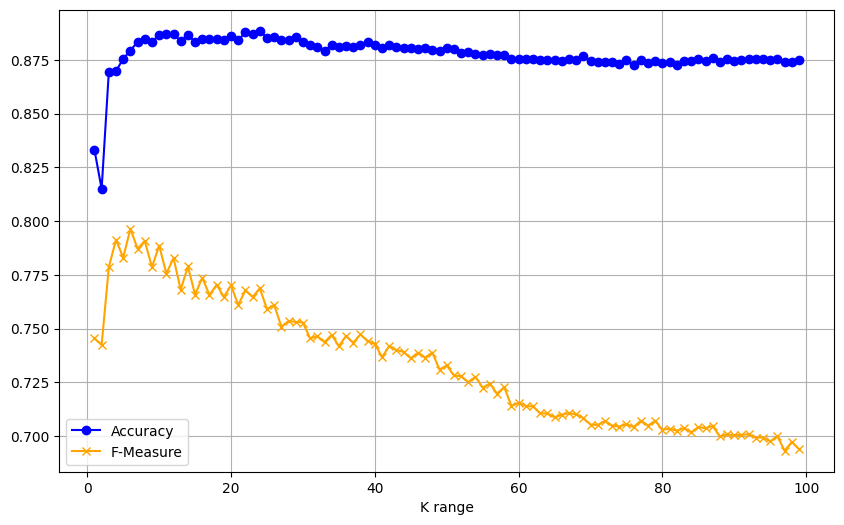

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(f_k_range, f_accuracies, color='b', marker='o', label='Accuracy')
plt.plot(f_k_range, f_f_measures, color='orange', marker='x', label='F-Measure')
plt.xlabel("K range")
plt.legend()
plt.grid()
plt.show()


### Comparison of accuracy using k found in the first cross-val and k' found in the cross-val using the f-measure

In [ ]:
test_accuracies_imb = []
test_errors_imb = []
test_f_measures_imb = []

range_imbalancy = np.arange(0.05, 0.6, 0.01)

n=10

for imbalancy in range_imbalancy : 
    x_train_imb, y_train_imb = generate_imbalancy(x_train, y_train, 2, imbalancy)
    
    dist_mat_test_train_imb = distance_matrix(x_test, x_train_imb)
    mean_acc = 0
    for _ in range(n):
        k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_train_imb, y_set_test=y_test, k=best_k, distance_mat=dist_mat_test_train_imb)
        mean_acc += k_acc
    mean_acc /= n
    test_accuracies_imb.append(mean_acc)
    test_errors_imb.append(k_error)
    test_f_measures_imb.append(k_f_measure)

test_accuracies_imb_new_k = []
test_errors_imb_new_k = []
test_f_measures_imb_new_k = []

for imbalancy in range_imbalancy : 
    x_train_imb, y_train_imb = generate_imbalancy(x_train, y_train, 2, imbalancy)
    
    dist_mat_test_train_imb = distance_matrix(x_test, x_train_imb)
    mean_acc = 0
    for _ in range(n):
        k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_train_imb, y_set_test=y_test, k=f_best_k, distance_mat=dist_mat_test_train_imb)
        mean_acc += k_acc
    mean_acc /= n
    test_accuracies_imb_new_k.append(mean_acc)
    test_errors_imb_new_k.append(k_error)
    test_f_measures_imb_new_k.append(k_f_measure)


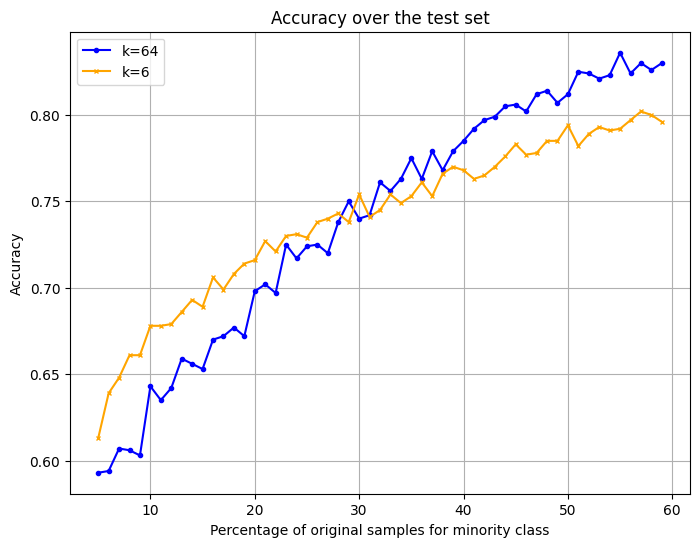

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range_imbalancy*100, test_accuracies_imb, marker='o', color='blue', label='k='+str(best_k), markersize=3)
plt.plot(range_imbalancy*100, test_accuracies_imb_new_k, marker='x', color='orange', label='k='+str(f_best_k), markersize=3)
plt.xlabel('Percentage of original samples for minority class')
plt.ylabel('Accuracy')
plt.title('Accuracy over the test set')
plt.grid()
plt.legend()
plt.show()


## Overcoming imbalancy

### Undersampling the other classes

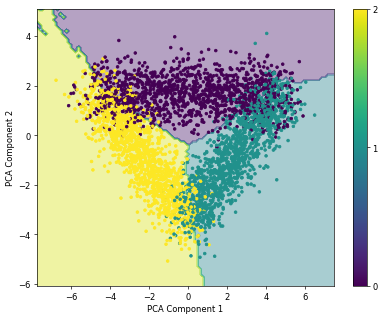

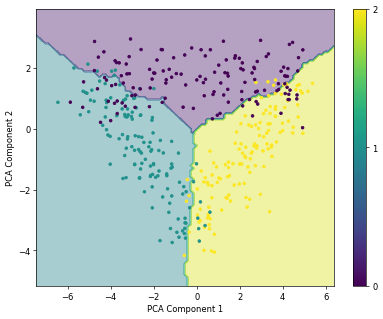

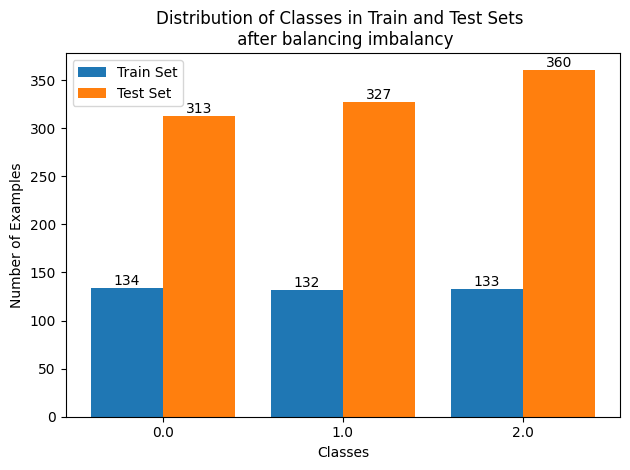

In [ ]:
undersampling_ratio = 0.1
x_imb, y_imb = generate_imbalancy(x_train, y_train, 0, undersampling_ratio)
x_imb, y_imb = generate_imbalancy(x_imb, y_imb, 1, undersampling_ratio)
x_under, y_under = generate_imbalancy(x_imb, y_imb, 2, undersampling_ratio)

x_pca_imb,_,_,_ = pca_train(x_under, 2)

plot_pca_boundaries(x_train_pca, y_train, k=best_k, resolution=100)

plot_pca_boundaries(x_pca_imb, y_under, k=best_k, resolution=100)

#Plotting the distribution of the training and test set
train_classes, train_counts = np.unique(y_under, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots()
bar_width = 0.4
train_positions = np.arange(len(train_classes))
test_positions = train_positions + bar_width
bar1 = ax.bar(train_positions, train_counts, bar_width, label='Train Set')
bar2 = ax.bar(test_positions, test_counts, bar_width, label='Test Set')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Examples')
ax.set_title('Distribution of Classes in Train and Test Sets \n after balancing imbalancy')
ax.set_xticks(train_positions + bar_width / 2)
ax.set_xticklabels(train_classes)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
ax.legend()
plt.tight_layout()
plt.show()


### Oversampling the minority class (SMOTE)

9.0
(3996, 21)


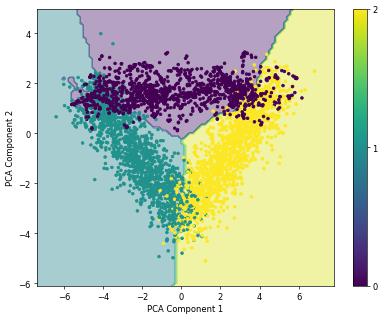

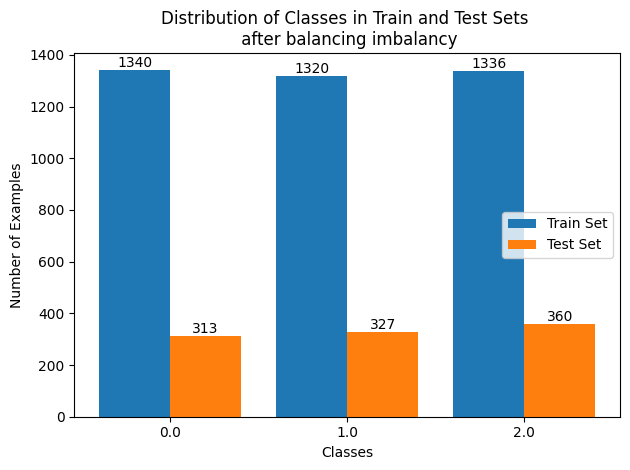

In [ ]:
def smote(features, labels, minority_class, oversampling_ratio, k_neighbors=5):
    # Extract minority class samples
    minority_indices = np.where(labels == minority_class)[0]
    minority_features = features[minority_indices]
    
    # Compute the distance matrix for the minority class
    dist_matrix = distance_matrix(minority_features, minority_features)
    
    # Identify k nearest neighbors for each sample (excluding itself)
    nearest_neighbors = np.argsort(dist_matrix, axis=1)[:, 1:k_neighbors + 1]

    # Calculate the number of synthetic samples to generate
    num_minority_samples = minority_features.shape[0]
    num_synthetic_samples = int(num_minority_samples * oversampling_ratio)

    # Generate synthetic samples
    synthetic_features = []
    for _ in range(num_synthetic_samples):
        # Randomly select a minority sample
        sample_idx = np.random.randint(0, num_minority_samples)
        
        # Randomly select one of its k nearest neighbors
        neighbor_idx = np.random.choice(nearest_neighbors[sample_idx])
        
        # Interpolate between the sample and its neighbor
        diff = minority_features[neighbor_idx] - minority_features[sample_idx]
        gap = np.random.rand()
        synthetic_sample = minority_features[sample_idx] + gap * diff

        synthetic_features.append(synthetic_sample)

    synthetic_features = np.array(synthetic_features)
    synthetic_labels = np.full(synthetic_features.shape[0], minority_class)

    augmented_features = np.vstack((features, synthetic_features))
    augmented_labels = np.hstack((labels.ravel(), synthetic_labels.ravel())) 

    return augmented_features, augmented_labels


minority_class = 0  
imbalancy_ratio = 0.1
oversampling_ratio = ((1-imbalancy_ratio)/imbalancy_ratio) 
print(oversampling_ratio)
k_neighbors = 10 

x_imb, y_imb = generate_imbalancy(x_train, y_train, minority_class, imbalancy_ratio)

x_smote, y_smote = smote(x_imb, y_imb, minority_class, oversampling_ratio, k_neighbors)

print(x_smote.shape)

x_smote_pca, _, _, _ = pca_train(x_smote, 2)
plot_pca_boundaries(x=x_smote_pca, y=y_smote, k=best_k, resolution=100)

#Plotting the distribution of the training and test set
train_classes, train_counts = np.unique(y_smote, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots()
bar_width = 0.4
train_positions = np.arange(len(train_classes))
test_positions = train_positions + bar_width
bar1 = ax.bar(train_positions, train_counts, bar_width, label='Train Set')
bar2 = ax.bar(test_positions, test_counts, bar_width, label='Test Set')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Examples')
ax.set_title('Distribution of Classes in Train and Test Sets \n after balancing imbalancy')
ax.set_xticks(train_positions + bar_width / 2)
ax.set_xticklabels(train_classes)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
ax.legend()
plt.tight_layout()
plt.show()



In [ ]:
test_accuracies_imb = []
dist_mat_test_imb = distance_matrix(x_test, x_imb)
test_accuracies_under = []
dist_mat_test_under = distance_matrix(x_test, x_under)
test_accuracies_smote = []
dist_mat_test_smote = distance_matrix(x_test, x_smote)

k_imb_range = range(1, 200)

for k in tqdm(k_imb_range) : 
    k_acc, _, _, _ = prediction_metrics(y_set_train=y_imb, y_set_test=y_test, k=k, distance_mat=dist_mat_test_imb)
    test_accuracies_imb.append(k_acc)

    k_acc, _, _, _ = prediction_metrics(y_set_train=y_under, y_set_test=y_test, k=k, distance_mat=dist_mat_test_under)
    test_accuracies_under.append(k_acc)

    k_acc, _, _, _ = prediction_metrics(y_set_train=y_smote, y_set_test=y_test, k=k, distance_mat=dist_mat_test_smote)
    test_accuracies_smote.append(k_acc)


100%|██████████| 199/199 [00:08<00:00, 23.36it/s]


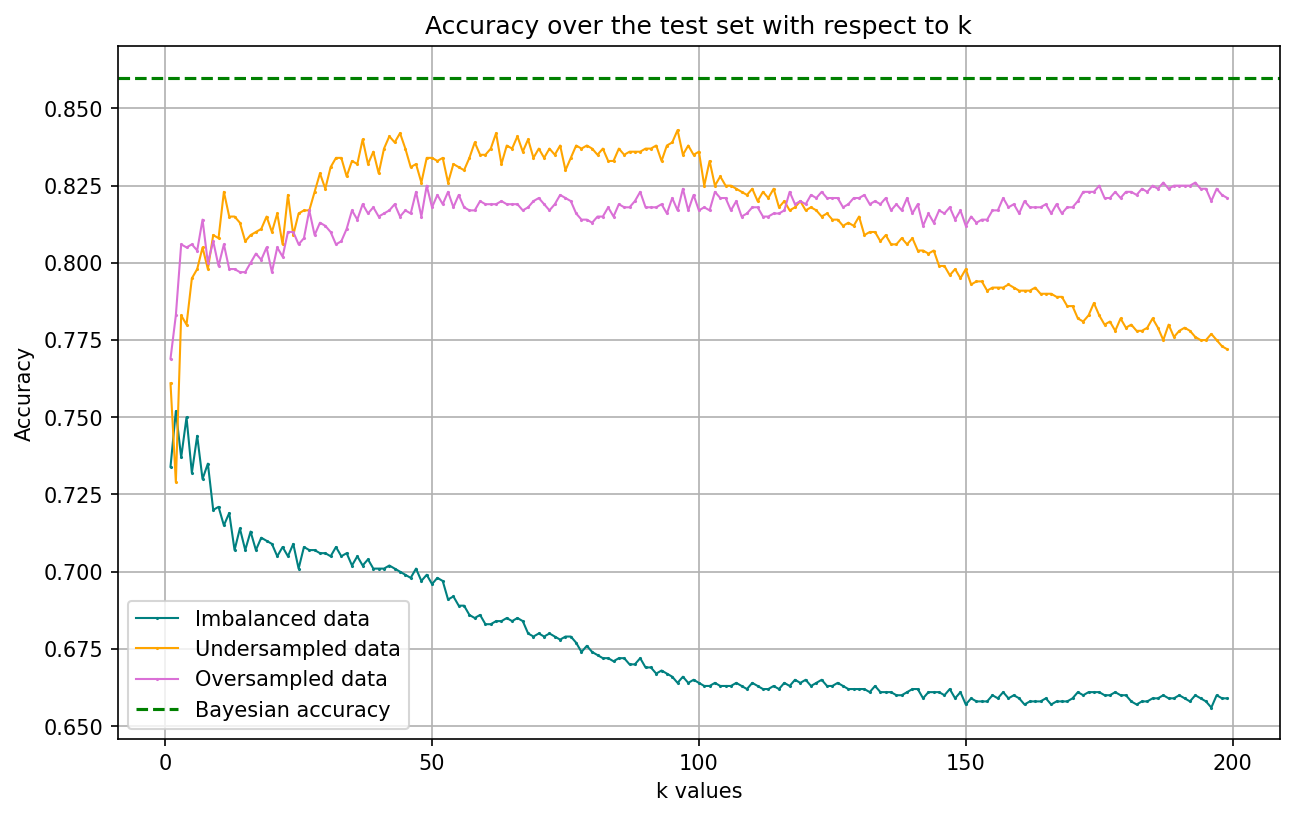

In [ ]:
plt.figure(figsize=(10, 6), dpi=150) 
mksize = 0.5
plt.plot(k_imb_range, test_accuracies_imb, label='Imbalanced data', marker='o', color='teal',markersize=mksize,linestyle='-', linewidth=1)
plt.plot(k_imb_range, test_accuracies_under, label='Undersampled data', marker='o', color='orange', markersize=mksize, linestyle='-', linewidth=1)
plt.plot(k_imb_range, test_accuracies_smote, label='Oversampled data', marker='o', color='orchid', markersize=mksize, linestyle='-', linewidth=1)
plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_imb_range)+2, 50))
#plt.yticks(np.arange(30, 90, 10)) 
#plt.axhline(y=(1/3), color='orange', linestyle='--', label=f'Random Guessing')
plt.grid(True)
plt.legend()
plt.title("Accuracy over the test set with respect to k")
plt.show()


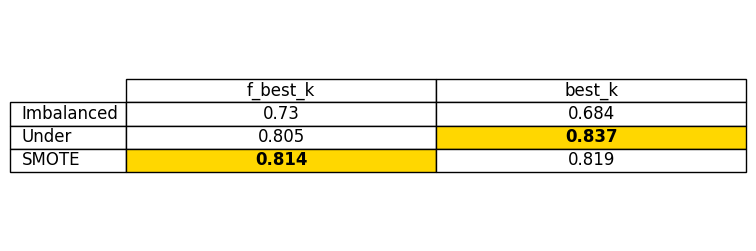

f_best_k - Imbalanced: 0.73
f_best_k - Under: 0.805
f_best_k - SMOTE: 0.814
best_k - Imbalanced: 0.684
best_k - Under: 0.837
best_k - SMOTE: 0.819


In [ ]:
data = {
    'f_best_k': [
        test_accuracies_imb[f_best_k],
        test_accuracies_under[f_best_k],
        test_accuracies_smote[f_best_k]
    ],
    'best_k': [
        test_accuracies_imb[best_k],
        test_accuracies_under[best_k],
        test_accuracies_smote[best_k]
    ]
}

row_labels = ['Imbalanced', 'Under', 'SMOTE']
df = pd.DataFrame(data, index=row_labels)

fig, ax = plt.subplots(figsize=(8, 3))  
ax.axis('tight')
ax.axis('off')

cell_text = df.values
col_labels = df.columns
row_labels = df.index

highlighted_cells = []
for col_idx, col_name in enumerate(df.columns):
    best_score = max(df[col_name])
    for row_idx, value in enumerate(df[col_name]):
        if value == best_score:
            highlighted_cells.append((row_idx, col_idx))

cell_font_size = 12  
cell_height = 0.1 

table = ax.table(cellText=cell_text, 
                 colLabels=col_labels, 
                 rowLabels=row_labels,
                 loc='center', 
                 cellLoc='center')

for (row_idx, col_idx), cell in table.get_celld().items():
    if (row_idx - 1, col_idx) in highlighted_cells: 
        cell.set_facecolor('#FFD700') 
        cell.set_text_props(weight='bold') 
    cell.set_fontsize(cell_font_size)
    cell.set_height(cell_height) 

plt.show()

print("f_best_k - Imbalanced:", test_accuracies_imb[f_best_k])
print("f_best_k - Under:", test_accuracies_under[f_best_k])
print("f_best_k - SMOTE:", test_accuracies_smote[f_best_k])
print("best_k - Imbalanced:", test_accuracies_imb[best_k])
print("best_k - Under:", test_accuracies_under[best_k])
print("best_k - SMOTE:", test_accuracies_smote[best_k])


# Distance metric

In [210]:
def euclidean_distances(X, Y):
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
    Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)
    distances_squared = X_norm + Y_norm - 2 * np.dot(X, Y.T)
    distances_squared = np.maximum(distances_squared, 0)
    return np.sqrt(distances_squared)

def manhattan_distances(X, Y):
    return np.sum(np.abs(X[:, np.newaxis, :] - Y[np.newaxis, :, :]), axis=2)

def cosine_distances(X, Y):
    X_norm = np.linalg.norm(X, axis=1).reshape(-1, 1)
    Y_norm = np.linalg.norm(Y, axis=1).reshape(1, -1)
    similarity = np.dot(X, Y.T) / (X_norm * Y_norm)
    return 1 - similarity

def chebyshev_distances(X, Y):
    return np.max(np.abs(X[:, np.newaxis, :] - Y[np.newaxis, :, :]), axis=2)

def hassanat_distance(X, Y):
    D = np.where(X[:, np.newaxis, :] >= 0, 
                 1 - (1 + np.minimum(X[:, np.newaxis, :], Y[np.newaxis, :])) / (1 + np.maximum(X[:, np.newaxis, :], Y[np.newaxis, :])), 
                 1 - (1 + np.minimum(X[:, np.newaxis, :], Y[np.newaxis, :]) + np.abs(np.minimum(X[:, np.newaxis, :], Y[np.newaxis, :]))) / (1 + np.maximum(X[:, np.newaxis, :], Y[np.newaxis, :]) + np.abs(np.minimum(X[:, np.newaxis, :], Y[np.newaxis, :]))))
    return np.sum(D, axis=2)

def canberra_distance(X, Y):
    return np.sum(np.abs(X[:, np.newaxis, :] - Y[np.newaxis, :, :]) / (np.abs(X[:, np.newaxis, :]) + np.abs(Y[np.newaxis, :, :])), axis=2)


In [211]:
def knn_optimized(X_train, y_train, X_test, k, metric_func):
    distances = metric_func(X_test, X_train)
    
    k_nearest_indices = np.argsort(distances, axis=1)[:, :k]
    
    k_nearest_labels = np.take(y_train, k_nearest_indices)
    
    predictions = np.array([np.bincount(row.astype(int)).argmax() for row in k_nearest_labels])
    return predictions


In [212]:
def cross_validate_knn_all_metrics(X_folds, y_folds, k_range, metrics):
    nb_folds = len(X_folds)
    metric_results = {metric_name: [] for metric_name in metrics}

    for metric_name, metric_func in tqdm(metrics.items()):
        for k in k_range:
            fold_accuracies = []
            for i in range(nb_folds):
                X_val, y_val = X_folds[i], y_folds[i]
                X_train = np.vstack([X_folds[j] for j in range(nb_folds) if j != i])
                y_train = np.hstack([y_folds[j].ravel() for j in range(nb_folds) if j != i])

                y_pred = knn_optimized(X_train, y_train, X_val, k, metric_func)

                accuracy = np.mean(y_pred == y_val.ravel())
                fold_accuracies.append(accuracy)
                
            metric_results[metric_name].append(np.mean(fold_accuracies))

    return metric_results


In [213]:
metrics = {
    "Euclidean": euclidean_distances,
    "Manhattan": manhattan_distances,
    "Cosine": cosine_distances,
    "Chebyshev": chebyshev_distances,
    "Hassanat": hassanat_distance,
    "Canberra" : canberra_distance,
}

X_folds, y_folds = k_folds(x_train, y_train, nb_folds=5)

k_range = range(1, 50)

metric_results = cross_validate_knn_all_metrics(X_folds, y_folds, k_range, metrics)


100%|██████████| 6/6 [11:26<00:00, 114.45s/it]


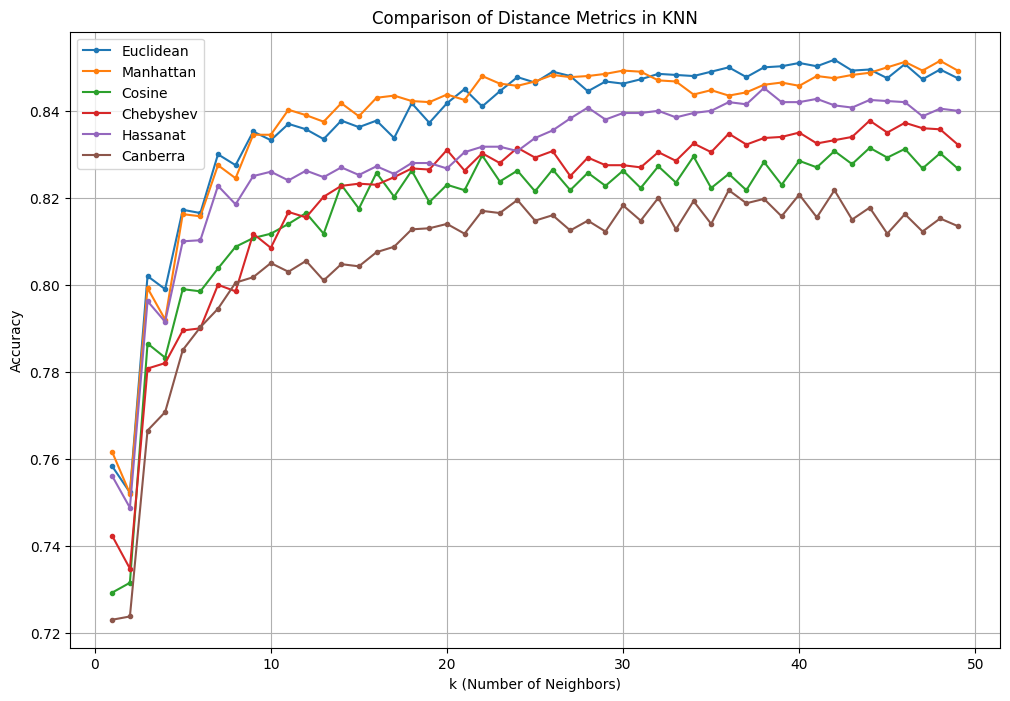

In [214]:
def plot_metric_comparisons(metric_results, k_range):
    plt.figure(figsize=(12, 8))

    for metric_name, accuracies in metric_results.items():
        plt.plot(k_range, accuracies, label=metric_name, marker='o', markersize=3)

    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Distance Metrics in KNN')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric_comparisons(metric_results, k_range)


In [215]:
x_train_pca, _, _, _ = pca_train(x_train, 2)

X_folds, y_folds = k_folds(x_train_pca, y_train, nb_folds=5)

metric_results_pca = cross_validate_knn_all_metrics(X_folds, y_folds, k_range, metrics)


100%|██████████| 6/6 [03:03<00:00, 30.66s/it]


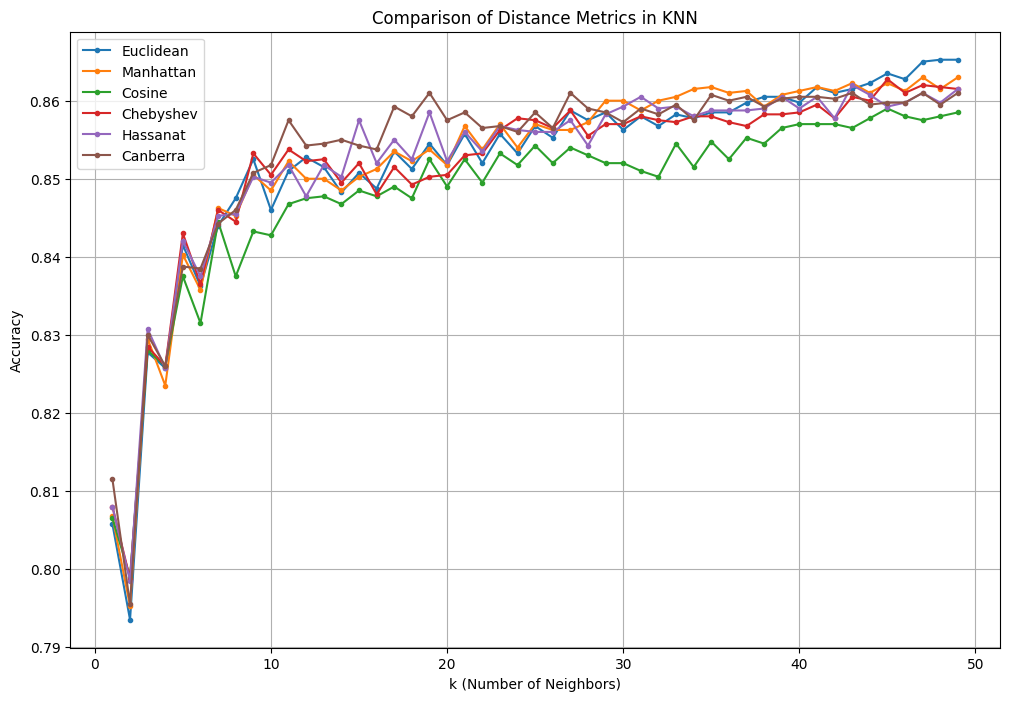

In [217]:
plot_metric_comparisons(metric_results_pca, k_range)
